# I. Data Preprocessing

In [23]:
import xml.etree.ElementTree as ET 
import numpy as np
import os 

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark) # relative? 

landmarks = np.array(landmarks).astype('float32')
bboxes = np.array(bboxes).astype('float32') 

In [24]:
# build a dataset
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

import numpy
import random
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [25]:
class IbugTrainingDataset(Dataset):
    def __init__(self, img_filenames, bboxes, landmarks, normalize=True, albu_transform=None):
        self.img_filenames = img_filenames
        self.bboxes = bboxes
        self.landmarks = landmarks
        # self.basic_transform = basic_transform # resize, totensor, normalize
        self.albu_transform = albu_transform # albumentations
        self.normalize = normalize

        if not self.normalize:
            print('Not normalizing the image')
        
    def __len__(self):
        return len(self.img_filenames)
    
    def __getitem__(self, idx):
        img_path = self.img_filenames[idx]
        opened_img = Image.open(img_path).convert('RGB') # range [0, 255] # shape (H, W, C)
        bounding_box = self.bboxes[idx]
        landmark_ori = self.landmarks[idx] # (68, 2)
        x, y, w, h = bounding_box # left, top, width, height
        cropped_by_bbox = opened_img.crop((x, y, x+w, y+h)) # shape (h, w, C)

        cropped_by_bbox = np.array(cropped_by_bbox) # range [0, 255] # shape (H, W, C)

        # to grayscale
        cropped_by_bbox = cv2.cvtColor(cropped_by_bbox, cv2.COLOR_RGB2GRAY) # shape (H, W)
        # resize
        cropped_by_bbox = cv2.resize(cropped_by_bbox, (224, 224))

        landmark = np.zeros_like(landmark_ori)
        landmark[:, 0] = landmark_ori[:, 0] - x
        landmark[:, 1] = landmark_ori[:, 1] - y
        landmark = landmark / [w, h] # relative coordinates
        
        # assert np.all(landmark == landmark2)
        # print("h: ", h, "w: ", w, "x: ", x, "y: ", y)
        
        # to relative coordinates
        if self.albu_transform:
            transformed = self.albu_transform(image=cropped_by_bbox, keypoints=landmark * 224)
            tfed_im = transformed['image'] # 68 tokens and each token has 224*224 classes
            landmark = transformed['keypoints'] / 224.
        else:
            tfed_im = cropped_by_bbox
            
        if self.normalize:
            tfed_im = tfed_im / 255.0 - 0.5 # shape (H, W, C)
        # print(tfed_im.shape)
        # return tfed_im, landmark
        return tfed_im, landmark
    

transform = A.Compose([
    A.Affine(rotate=(-15, 15), translate_percent={'x': 0.1, 'y': 0.1}),
    # A.HorizontalFlip(p=0.5), # FIXED: DONT USE THIS
    # A.GaussNoise(p=0.5), # DO WE NEED THIS?
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

dataset = IbugTrainingDataset(img_filenames, bboxes, landmarks, normalize=True, albu_transform=transform)

# II. Model Architecture
We use ResNet and substitute the first convolutional layer with one that has 1 input channel; we also change the last fully connected layer to output 68*2=136 values.

In [2]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, resnet50, resnet34, resnet101, resnet152, resnext50_32x4d, resnext101_32x8d
# 32x4d, 32x8d means  32 groups, 4 and 8 are the width of each group

In [3]:
class ResNetforFacialLandmarks(nn.Module):
    def __init__(self, in_channels=1, num_landmark=68, dim_landmark=2, resnet=resnet18):
        super(ResNetforFacialLandmarks, self).__init__()
        self.resnet = resnet(pretrained=True)
        # in channel: 1
        # fc layer last dim: 68*2
        self.resnet.conv1 = nn.Conv2d(in_channels,
                                        self.resnet.conv1.out_channels,
                                        kernel_size=self.resnet.conv1.kernel_size,
                                        stride=self.resnet.conv1.stride, 
                                        padding=self.resnet.conv1.padding,
                                        bias=self.resnet.conv1.bias is not None) # (N, 1, 224, 224) -> (N, 64, 112, 112)
        
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_landmark*dim_landmark)
        
    def forward(self, x):
        return self.resnet.forward(x).view(x.size(0), -1, 2) # (N, 68, 2)

# III. Training

We use ResNeXt50 with 32 groups of convolutions (32 paths) with 4 channels each path. Also, we use a LR of 5e-4 with a batch size of 64. We train for 40 epochs.

In [28]:
# plot
import matplotlib.pyplot as plt
from tqdm import tqdm
!nvidia-smi

Mon Dec  9 22:53:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8              1W /   80W |    6619MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetforFacialLandmarks(resnet=resnet50).to(device)
# init
# def init_weights(m):
#     if type(m) == nn.Linear:
#         torch.nn.init.xavier_uniform_(m.weight)
#         m.bias.data.fill_(0.01)
#     elif type(m) == nn.Conv2d:
#         torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#         if m.bias is not None:
#             m.bias.data.fill_(0.01)
criterion = nn.MSELoss()
mae = nn.L1Loss()
# criterion = nn.SmoothL1Loss() # TODO: Try Huber loss
LR = 5e-4
# WD = 1e-5
# WD = 0.25
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
epochs = 20
batch_size = 64

# split the dataset
seed_everything(42)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# loaders
seed_everything(42)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
!nvidia-smi

/home/it/miniforge3/envs/180/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/it/miniforge3/envs/180/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mon Dec  9 22:53:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0              4W /   80W |    6619MiB /   8188MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [30]:
# train
train_losses = []
val_losses = []

seed_everything(42)
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    loop = tqdm(total=len(train_loader), position=0, leave=True)
    loop.set_description(f'Epoch {epoch+1}/{epochs}')
    for i, (images, landmarks) in enumerate(train_loader):
        images = images.to(device)
        # print(images.shape)
        landmarks = landmarks.to(device)
        optimizer.zero_grad()
        outputs = model.forward(images)
        loss = criterion(outputs, landmarks)
        with torch.no_grad():
            mae_loss = mae(outputs, landmarks) * 224
            train_mae += mae_loss.item()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # loop.set_postfix(train_loss=loss.item(), mae=mae.item())
        loop.set_postfix(train_loss=loss.item(), train_mae=mae_loss.item())
        loop.update(1)
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_mae /= len(train_loader)
    
    
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    loop = tqdm(total=len(val_loader), position=0, leave=True)
    loop.set_description(f'Epoch {epoch+1}/{epochs}')
    with torch.no_grad():
        for i, (images, landmarks) in enumerate(val_loader):
            images = images.to(device)
            landmarks = landmarks.to(device)
            outputs = model(images)
            loss = criterion(outputs, landmarks)
            mae_loss = mae(outputs, landmarks) * 224
            val_mae += mae_loss.item()
            val_loss += loss.item()
            loop.set_postfix(val_loss=loss.item(), val_mae=mae_loss.item())
            loop.update(1)
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_mae /= len(val_loader)
        
    tqdm.write(f'Epoch {epoch+1}/{epochs}, avg_train_loss: {train_loss}, avg_val_loss: {val_loss},\
               avg_train_mae: {train_mae}, avg_val_mae: {val_mae}')
    # loop.set_postfix(train_loss=train_loss, val_loss=val_loss)
    loop.close()

Epoch 1/20: 100%|██████████| 11/11 [00:02<00:00,  4.76it/s, val_loss=0.00809, val_mae=16.2]


Epoch 1/20, avg_train_loss: 0.015592725843468562, avg_val_loss: 0.008024017749862238,               avg_train_mae: 17.035026661893156, avg_val_mae: 15.618242697282271


Epoch 2/20: 100%|██████████| 11/11 [00:02<00:00,  4.90it/s, val_loss=0.025, val_mae=25.4]


Epoch 2/20, avg_train_loss: 0.005305217702853236, avg_val_loss: 0.026886027475649662,               avg_train_mae: 12.546364094348665, avg_val_mae: 26.06426863236861


Epoch 3/20: 100%|██████████| 11/11 [00:02<00:00,  4.88it/s, val_loss=0.00402, val_mae=11] 


Epoch 3/20, avg_train_loss: 0.0038655730202159983, avg_val_loss: 0.0038531058764254503,               avg_train_mae: 10.660729570591704, avg_val_mae: 10.746211658824574


Epoch 4/20: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s, val_loss=0.00197, val_mae=7.23]


Epoch 4/20, avg_train_loss: 0.0022925574708967766, avg_val_loss: 0.001695112685080279,               avg_train_mae: 8.085614407316168, avg_val_mae: 6.750055703249845


Epoch 5/20: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s, val_loss=0.00329, val_mae=9.64]


Epoch 5/20, avg_train_loss: 0.0019708064612635272, avg_val_loss: 0.002904501764781096,               avg_train_mae: 7.4312153623459185, avg_val_mae: 9.174153674732555


Epoch 6/20: 100%|██████████| 11/11 [00:02<00:00,  4.86it/s, val_loss=0.00194, val_mae=7.74]


Epoch 6/20, avg_train_loss: 0.0015589003259207101, avg_val_loss: 0.0018044167875566266,               avg_train_mae: 6.665250347015705, avg_val_mae: 7.475559321316806


Epoch 7/20: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s, val_loss=0.00125, val_mae=5.9] 


Epoch 7/20, avg_train_loss: 0.001307209078073898, avg_val_loss: 0.0011704234215854244,               avg_train_mae: 6.116527592882197, avg_val_mae: 5.616053581237793


Epoch 8/20: 100%|██████████| 11/11 [00:02<00:00,  4.77it/s, val_loss=0.00108, val_mae=5.41] 


Epoch 8/20, avg_train_loss: 0.0011416137233336873, avg_val_loss: 0.0010024515795521438,               avg_train_mae: 5.7167945516870375, avg_val_mae: 5.1624014594338155


Epoch 9/20: 100%|██████████| 11/11 [00:02<00:00,  4.70it/s, val_loss=0.00146, val_mae=6.59]


Epoch 9/20, avg_train_loss: 0.0010957039900104258, avg_val_loss: 0.0015404008286581798,               avg_train_mae: 5.6291344165802, avg_val_mae: 6.759453079917214


Epoch 10/20: 100%|██████████| 11/11 [00:02<00:00,  4.83it/s, val_loss=0.000973, val_mae=5.11]


Epoch 10/20, avg_train_loss: 0.0010029875804630525, avg_val_loss: 0.000981767524287782,               avg_train_mae: 5.392534778473225, avg_val_mae: 5.093148491599343


Epoch 11/20: 100%|██████████| 11/11 [00:02<00:00,  4.86it/s, val_loss=0.000975, val_mae=5.17]


Epoch 11/20, avg_train_loss: 0.0009275603453638626, avg_val_loss: 0.0009355049485086718,               avg_train_mae: 5.162549729042865, avg_val_mae: 4.98313756422563


Epoch 12/20: 100%|██████████| 11/11 [00:02<00:00,  4.96it/s, val_loss=0.000915, val_mae=4.98]


Epoch 12/20, avg_train_loss: 0.0009399945668113279, avg_val_loss: 0.0008760446005246856,               avg_train_mae: 5.221858618107248, avg_val_mae: 4.80938230861317


Epoch 13/20: 100%|██████████| 11/11 [00:02<00:00,  4.74it/s, val_loss=0.00092, val_mae=5.04] 


Epoch 13/20, avg_train_loss: 0.0009447726993227101, avg_val_loss: 0.0008740166720764881,               avg_train_mae: 5.275661316323788, avg_val_mae: 4.846304980191317


Epoch 14/20: 100%|██████████| 11/11 [00:02<00:00,  4.87it/s, val_loss=0.000948, val_mae=5.05]


Epoch 14/20, avg_train_loss: 0.0009600155332938154, avg_val_loss: 0.0008915228800932792,               avg_train_mae: 5.2988894087203, avg_val_mae: 4.786146900870583


Epoch 15/20: 100%|██████████| 11/11 [00:02<00:00,  4.94it/s, val_loss=0.000885, val_mae=4.83]


Epoch 15/20, avg_train_loss: 0.0008034750619814037, avg_val_loss: 0.0008332499842667444,               avg_train_mae: 4.8155527317777596, avg_val_mae: 4.658012086694891


Epoch 16/20: 100%|██████████| 11/11 [00:02<00:00,  4.67it/s, val_loss=0.000794, val_mae=4.45]


Epoch 16/20, avg_train_loss: 0.000869841015144707, avg_val_loss: 0.0006779081992466341,               avg_train_mae: 5.019311950561848, avg_val_mae: 4.126950914209539


Epoch 17/20: 100%|██████████| 11/11 [00:02<00:00,  4.72it/s, val_loss=0.00079, val_mae=4.65] 


Epoch 17/20, avg_train_loss: 0.0007423786923259575, avg_val_loss: 0.0007488354881802065,               avg_train_mae: 4.598239586708393, avg_val_mae: 4.4512035629966045


Epoch 18/20: 100%|██████████| 11/11 [00:02<00:00,  4.39it/s, val_loss=0.000782, val_mae=4.51]


Epoch 18/20, avg_train_loss: 0.000866867367802386, avg_val_loss: 0.0007311165999536487,               avg_train_mae: 5.039608412600578, avg_val_mae: 4.2534161047502


Epoch 19/20: 100%|██████████| 11/11 [00:02<00:00,  4.85it/s, val_loss=0.000781, val_mae=4.61]


Epoch 19/20, avg_train_loss: 0.0008416740128403886, avg_val_loss: 0.0007256511598825455,               avg_train_mae: 4.966663670032583, avg_val_mae: 4.369356848976829


Epoch 20/20: 100%|██████████| 11/11 [00:02<00:00,  4.97it/s, val_loss=0.000905, val_mae=4.74]

Epoch 20/20, avg_train_loss: 0.0007418263059585018, avg_val_loss: 0.0008077251470901749,               avg_train_mae: 4.659584570438303, avg_val_mae: 4.562003742564809


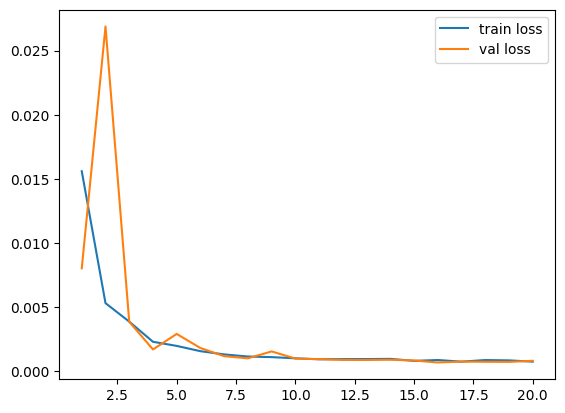

In [31]:
plt.plot(range(1, epochs+1), train_losses, label='train loss')
plt.plot(range(1, epochs+1), val_losses, label='val loss')
plt.legend()
os.makedirs('3', exist_ok=True)
plt.savefig('3/losses.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# save the ckpt
if True:
    torch.save(model.state_dict(), '3/model.pth')

# IV. Testing

20 epochs, 5e-4 LR, 64 as the batch size make the model have a good performance in testing, getting a public and private score of about 8.5 which is the testing MAE.

In [33]:
# validation MAE
# mae_criterion = nn.L1Loss()
# model.eval()
# with torch.no_grad():
#     val_mae = 0.0
#     # want original image and landmark
#     val_dataset_original = IbugTrainingDataset(img_filenames, bboxes, landmarks, basic_transform=basic_transform, albu_transform=transform, original=True)
#     val_loader_original = torch.utils.data.DataLoader(val_dataset_original, batch_size=batch_size, shuffle=False, num_workers=16)
#     for i, (images, landmarks, bbox, landmark_ori) in enumerate(val_loader_original):
#         images = images.to(device)
#         landmarks = landmarks.to(device)
#         outputs = model(images)
#         x, y, w, h = bbox[0]
#         outputs[:, :, 0] = outputs[:, :, 0] * w + x
#         outputs[:, :, 1] = outputs[:, :, 1] * h + y
#         mae = mae_criterion(outputs, landmark_ori.to(device))
#         val_mae += mae.item()
#     val_mae /= len(val_loader_original)
#     print(f'Validation MAE: {val_mae}')

In [34]:
# %pip install pandas
import xml.etree.ElementTree as ET 
import numpy as np
import pandas as pd
import os 

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test_parsed.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

bboxes = np.array(bboxes).astype('float32') 
print(bboxes.shape)
print(len(img_filenames))
print(img_filenames[0])

(1008, 4)
1008
ibug_300W_large_face_landmark_dataset/helen/trainset/146827737_1.jpg


In [35]:
# we now have img_filenames and bboxes
# for every i in range(len(img_filenames)), 
# we crop the image, resize it to (224, 224), and then feed it to the model
# the output is the landmarks in shape (68, 2)
class IBugTestDataset(Dataset):
    def __init__(self, img_filenames, bboxes, normalize=True):
        self.img_filenames = img_filenames
        self.bboxes = bboxes
        self.normalize = normalize
        
    def __len__(self):
        return len(self.img_filenames)
    
    def __getitem__(self, idx):
        img_path = self.img_filenames[idx]
        # grayscale
        opened_img = Image.open(img_path).convert('RGB') # range [0, 255] # shape (H, W, C)
        bounding_box = self.bboxes[idx]
        x, y, w, h = bounding_box # left, top, width, height
        cropped_by_bbox = opened_img.crop((x, y, x+w, y+h))
        cropped_by_bbox = np.array(cropped_by_bbox) # range [0, 255]
        cropped_by_bbox = cv2.cvtColor(cropped_by_bbox, cv2.COLOR_RGB2GRAY)
        cropped_by_bbox = cv2.resize(cropped_by_bbox, (224, 224))
        if self.normalize:
            cropped_by_bbox = cropped_by_bbox / 255.0 - 0.5
        # print(cropped_by_bbox.shape) # (224, 224)
        cropped_by_bbox = np.expand_dims(cropped_by_bbox, axis=0) # (1, 224, 224)
        cropped_by_bbox = torch.from_numpy(cropped_by_bbox).float() # (1, 224, 224)
        return cropped_by_bbox, bounding_box
    
basic_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), # From (C, H, W) to (C, 224, 224)
    # grayscale
    # transforms.Grayscale(num_output_channels=1), # From (C, H, W) to (1, H, W)
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = IBugTestDataset(img_filenames, bboxes, normalize=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# test
model.eval()
preds = []
with torch.no_grad():
    for (images, bbox) in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images) # (N, 68, 2)
        # for every output in outputs, we should get the absolute coordinates
        outputs = outputs.cpu().numpy()
        for j, output in enumerate(outputs):
            x, y, w, h = bbox[j]
            # x, y, w, h = int(x), int(y), int(w), int(h)
            output[:, 0] = output[:, 0] * w + x
            output[:, 1] = output[:, 1] * h + y
            # output: (68, 2)
            preds.append(output)


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


In [37]:
alternating_names = [] # should be 136 * test_size(1008) = 137088
alternating_values = []
counter = 0
for i in range(len(preds)):
    pred = preds[i] # (68, 2)
    
    for j in range(68):
        # alternating_names.append(f'image_{i+1}_keypoints_{j+1}_x')
        alternating_names.append(str(counter))
        counter += 1
        alternating_names.append(str(counter))
        counter += 1
        # alternating_names.append(f'image_{i+1}_keypoints_{j+1}_y')
        
        alternating_values.append(pred[j][0]) # x
        alternating_values.append(pred[j][1]) # y
        
        
        
df = pd.DataFrame({'Id': alternating_names, 'Predicted': alternating_values})

os.makedirs('3', exist_ok=True)
df.to_csv('3/submission.csv', index=False)
!cd 3 && ls -l && kaggle competitions submit -c cs194-26-fall-2022-project-5 -f submission.csv -m "ResNet50, 20 epochs, 5e-4 LR, 64 bs, 0 WD, Huber, 0.1 color jitter, 0.1 translate, 0.1 rotate"


total 101508
-rw-rw-r-- 1 it it    86504 12月  9 23:05 losses.png
-rw-rw-r-- 1 it it 95424874 12月  9 22:34 model.pth
-rw-rw-r-- 1 it it   170171 12月  9 22:51 my1.jpg
-rw-rw-r-- 1 it it    88780 12月  9 22:51 my2.jpg
-rw-rw-r-- 1 it it    66092 12月  9 22:50 my3.jpg
-rw-rw-r-- 1 it it  2169916 12月  9 23:05 submission.csv
-rw-rw-r-- 1 it it  5921583 12月  9 22:50 test_first_4_images.png
100%|██████████████████████████████████████| 2.07M/2.07M [00:01<00:00, 1.57MB/s]
Successfully submitted to CS194-26 Fall 2022 Project 5

We visualize 4 test images and their predicted keypoints.

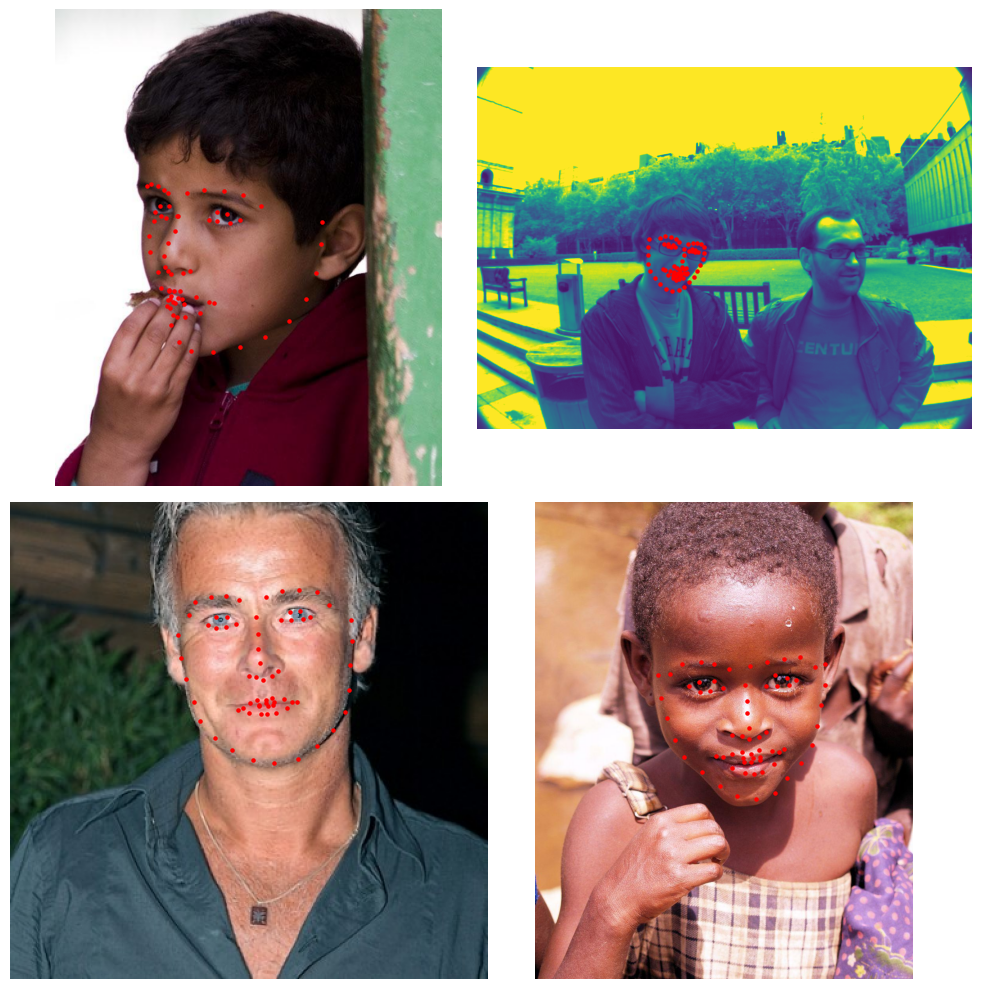

In [38]:
# first 4 images in testset
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for i in range(4):
    img = Image.open(img_filenames[i])
    ax = axes[i]
    ax.imshow(img)
    ax.scatter(preds[i][:, 0], preds[i][:, 1], c='r', s=5)
    ax.axis('off')
    
plt.tight_layout()
plt.savefig('3/test_first_4_images.png', dpi=300, bbox_inches='tight')
plt.show()

On images from my collection...

In [39]:
from PIL import Image

(283, 213)


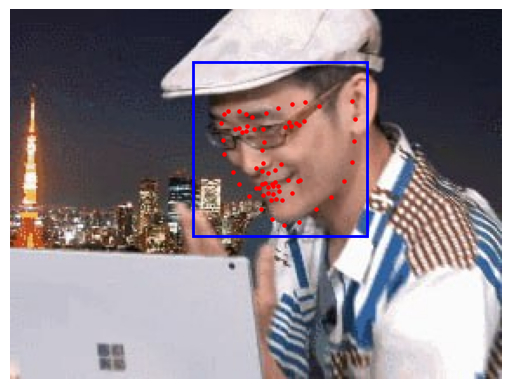

In [40]:
# 1.jpg
with torch.no_grad():
    im1_ori = Image.open('my_ims/1.jpg')
    print(im1_ori.size)
    x, y, w, h = 105, 30, 100, 100
    im1 = im1_ori.crop((x, y, x+w, y+h)).resize((224, 224))
    im1 = im1.convert('RGB')
    im1 = np.array(im1)
    im1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
    im1 = im1 / 255.0 - 0.5 # normalize
    im1 = torch.tensor(im1).unsqueeze(0).unsqueeze(0).to(device) # (1, 1, 224, 224)
    im1 = im1.float()
    output = model(im1) # (1, 68, 2)
    output = output.cpu().numpy()
    output = output[0] # (68, 2)
    rect = plt.Rectangle((x, y), w, h, fill=False, color='blue', linewidth=2)
    plt.gca().add_patch(rect)
    # absolute coordinates
    output[:, 0] = output[:, 0] * w + x
    output[:, 1] = output[:, 1] * h + y
    # also show the bounding box
    
    plt.imshow(im1_ori)
    plt.scatter(output[:, 0], output[:, 1], c='r', s=5)
    plt.axis('off')
    plt.savefig('3/my1.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

(429, 375)


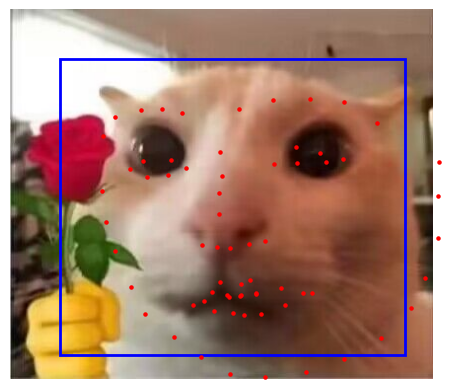

In [41]:
# 2.jpg
with torch.no_grad():
    im2_ori = Image.open('my_ims/2.jpg')
    print(im2_ori.size)
    x, y, w, h = 50, 50, 350, 300
    im2 = im2_ori.crop((x, y, x+w, y+h)).resize((224, 224))
    im2 = im2.convert('L')
    im2 = np.array(im2)
    im2 = im2 / 255.0 - 0.5 # normalize
    im2 = torch.tensor(im2).unsqueeze(0).unsqueeze(0).to(device) # (1, 1, 224, 224)
    im2 = im2.float()
    output = model(im2) # (1, 68, 2)
    output = output.cpu().numpy()
    output = output[0] # (68, 2)
    rect = plt.Rectangle((x, y), w, h, fill=False, color='blue', linewidth=2)
    plt.gca().add_patch(rect)
    # absolute coordinates
    output[:, 0] = output[:, 0] * w + x
    output[:, 1] = output[:, 1] * h + y
    # also show the bounding box
    
    plt.imshow(im2_ori)
    plt.scatter(output[:, 0], output[:, 1], c='r', s=5)
    plt.axis('off')
    plt.savefig('3/my2.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

(467, 453)


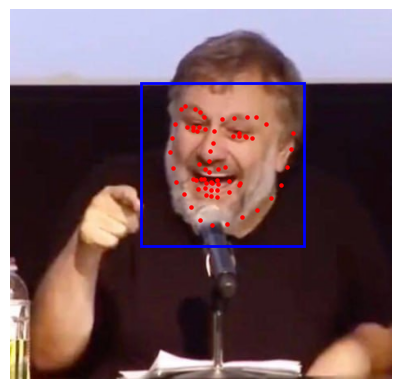

In [42]:
# 3.jpg
with torch.no_grad():
    im3_ori = Image.open('my_ims/3.jpg')
    print(im3_ori.size)
    x, y, w, h = 160, 90, 200, 200
    im3 = im3_ori.crop((x, y, x+w, y+h)).resize((224, 224))
    im3 = im3.convert('L')
    im3 = np.array(im3)
    im3 = im3 / 255.0 - 0.5 # normalize
    im3 = torch.tensor(im3).unsqueeze(0).unsqueeze(0).to(device) # (1, 1, 224, 224)
    im3 = im3.float()
    output = model(im3) # (1, 68, 2)
    output = output.cpu().numpy()
    output = output[0] # (68, 2)
    rect = plt.Rectangle((x, y), w, h, fill=False, color='blue', linewidth=2)
    plt.gca().add_patch(rect)
    # absolute coordinates
    output[:, 0] = output[:, 0] * w + x
    output[:, 1] = output[:, 1] * h + y
    # also show the bounding box
    
    plt.imshow(im3_ori)
    plt.scatter(output[:, 0], output[:, 1], c='r', s=5)
    plt.axis('off')
    plt.savefig('3/my3.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

In [ ]:
from torchsummary import summary
model.to('cpu')
summary(model, (1, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,